<a href="https://colab.research.google.com/github/ucbnlp24/hws4nlp24/blob/main/HW6/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 6: Encoder-Decoder Model and Machine Translation Evaluation

### Due Date: April 18th, 2024 (11:59pm)

**Grading**: To complete the homework assignment, you should implement anything marked with `#TO-DO` and replace `variable = None` with your solutions.
  - **NOTE #1**: Keep your code between the `#BEGIN SOLUTION` and `#END SOLUTION` flags
  - **NOTE #2**: For grading purposes, DO NOT change the variable names in the return statement

# 1. Encoder-decoder model with cross-attention

For deliverable 1, you'll implement an encoder-decoder model with cross-attention, as described in [SLP3 13.3](https://web.stanford.edu/~jurafsky/slp3/13.pdf).  Most of the model has been laid out for you.  Your task is to study the details as described in the book, and implement the `CrossAttentionBlock`, which allows tokens on the decoding side (e.g., a French translation you are generating) to attend to information on the encoding side (e.g., an original English sentence you're translating).  You'll implement the `CrossAttentionBlock` and the `forward` function within an Encoder-Decoder model that puts it all together to generate a sequence of tokens.  For this homework, only use the libraries that have been imported (don't import any new libraries).

For all attention blocks (both self-attention and cross-attention), you'll only implement the attention layer within them; while attention blocks have other components (residual layer, layer normalization, feedforward layer), you can pretend they don't exist: the goal of is homework is for you to understand how *cross-attention* in particular works within an encoder-decoder model, so you can ignore those other components in doing so.


In [ ]:
from math import sqrt, log, exp
import torch
from torch import nn
from collections import Counter
import numpy as np

torch.manual_seed(0)

First, let's implement a standard self-attention block (again, forgetting about the residual layer, layer normalization, and feedforward layer).

In [ ]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        self.dim=hidden_dim
        self.encoder_Wq=torch.nn.Linear(input_dim, hidden_dim)
        self.encoder_Wk=torch.nn.Linear(input_dim, hidden_dim)
        self.encoder_Wv=torch.nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        encoder_q=self.encoder_Wq(x)
        encoder_k=self.encoder_Wk(x)
        encoder_v=self.encoder_Wv(x)
        mm=torch.mm(encoder_q, torch.transpose(encoder_k, 0, 1))

        attention_weights=self.softmax(( mm )/sqrt(self.dim))
        output=attention_weights @ encoder_v

        return output


Using the SelfAttentionBlock as a model, implement the `CrossAttentionBlock` as illustrated in SLP3 figure 13.6 (shown below and described in this section).  

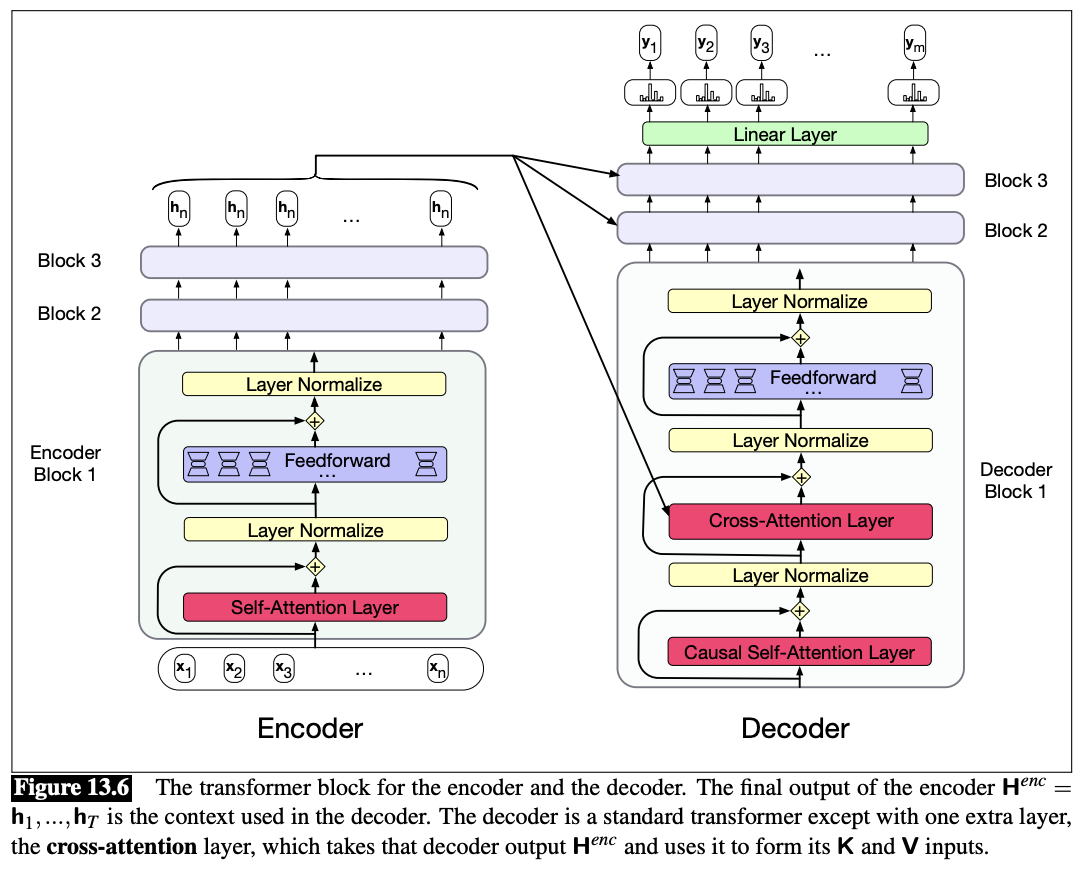

Keep in mind that the forward function of this method takes in information about `x` (the input tokens you are trying to translate) and `y` (the output tokens you are decoding).  In the `EncoderDecoder` class below, the input `x` to the forward function should be the `encoder_outputs`.

In [ ]:
class CrossAttentionBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):  
        super().__init__()

        # BEGIN SOLUTION
        # TO-DO 
        self.dim=None
        self.encoder_Wq=None 
        self.encoder_Wk=None 
        self.encoder_Wv=None 
        self.softmax=None
        
        # END SOLUTION

    def forward(self, x, y): 

        # BEGIN SOLUTION
        # TO-DO 
        encoder_q=None 
        encoder_k=None 
        encoder_v=None
        mm=None
        
        attention_weights=None
        output=None
        
        # END SOLUTION

        # Do not change the variable name!
        return output

With those attention blocks, implement the encoder-decoding model as illustrated in SLP3 figure 13.6 (and described in this section).  Do not implement layer normalization, residual layers or feedforward layers; only the self-attention layers, cross-attention layer, and final linear layer.  We provide the components for you in the initializer; your task is to assemble them in the correct way in the forward function.

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_encoder_layers=2, num_decoder_layers=2, x_vocab_size=1000, y_vocab_size=1000):  
        super().__init__()
        
        self.num_encoder_layers=num_encoder_layers
        self.num_decoder_layers=num_decoder_layers

        self.x_embeddings=torch.nn.Embedding(x_vocab_size,input_dim)
        self.y_embeddings=torch.nn.Embedding(y_vocab_size,input_dim)
        
        self.encoder_blocks=[SelfAttentionBlock(input_dim, hidden_dim) for _ in range(self.num_encoder_layers)]

        self.decoder_causal_blocks=[SelfAttentionBlock(input_dim, hidden_dim) for _ in range(self.num_decoder_layers)]
        self.cross_attention_blocks=[CrossAttentionBlock(input_dim, hidden_dim) for _ in range(self.num_decoder_layers)]

        self.linear_to_output_vocab=torch.nn.Linear(input_dim, y_vocab_size)

    def forward(self, x): 

        # y_int is the sequence of token IDs that we've generated; let's assume vocab ID = 0 
        # is the START symbol, so we'll initialize the list to that.
        
        y_int=[0]

        # let's get encodings of x
        
        encoder_outputs=self.x_embeddings(x)
        for i in range(self.num_encoder_layers):
            encoder_outputs=self.encoder_blocks[i](encoder_outputs)

        # now let's decode; for this exercise, we'll generate exactly 10 tokens (trained MT systems 
        # would stop when they predict the STOP symbol).
        
        for i in range(10):
            
            # let's get embeddings of the tokens we've generated so far
            
            y=self.y_embeddings(torch.LongTensor(y_int))

            # you implement the rest. The output variable should be a matrix of size [ len(y_int), 1000 ]
            
            # BEGIN SOLUTION
            # TO-DO (Do not change the variable name!)
            output=None
            # END SOLUTION  
            
            # from the output we'll select the vocab ID with the highest score and add that to token 
            # IDs we've generated
                
            choice=torch.argmax(output[-1])
            y_int.append(choice)
        

In [ ]:
model=EncoderDecoder(100, 37)
input_x=torch.LongTensor([37, 2, 10])
model.forward(input_x)

# 2. Implement BLEU

BLEU is a common method method for evaluation the performance of MT systems.  For this deliverable, you will implement BLEU and evaluate a sample translation with respect to several reference translations.  Refer to lecture, but here is the equation for BLEU:

$$
\textrm{BLEU} = BP \times \exp {1\over N} \sum_{n=1}^N \log p_n
$$

Where:
$$
p_n = {\textrm{Number of ngram tokens in system and reference translations} \over \textrm{Number of ngram tokens in system translation}}
$$

And:

The brevity penalty = $\exp(1-r/c)$, where $c$ is the length of the hypothesis translation (in tokens), and $r$ is the length of the *closest* reference translation.

Calculate BLEU for $N=4$.  Your code should return six values, in order:

* bleu
* $p_1$
* $p_2$
* $p_3$
* $p_4$
* the brevity penalty

In [ ]:
hypothesis="Abandon all hope , ye who enter here"
references=["All hope abandon , ye who enter here", "All hope abandon , ye who enter in !", "Leave every hope, ye that enter", "Leave all hope , ye that enter"]

In [ ]:
# helper function to get n-grams from a given text
def get_ngrams(text, order):
    """
    Given a string `text` and an integer `order`, returns a Counter object containing
    the frequency counts of all ngrams of size `order` in the string.
    """
    ngrams = Counter()

    # BEGIN SOLUTION
    # TO-DO (Do not change the variable name!)
    # END SOLUTION

    return ngrams

In [ ]:
print(dict(get_ngrams(hypothesis, 2))) # sanity check: expected output should be
# {'Abandon all': 1, 'all hope': 1, 'hope ,': 1, ', ye': 1, 'ye who': 1, 'who enter': 1, 'enter here': 1}

In [ ]:
def calculate_bleu(hypothesis, references):
    
    bleu=None
    p1=None
    p2=None
    p3=None
    p4=None
    bp=None
    
    # BEGIN SOLUTION

    # 1. find the closest reference to the hypothesis
    closest_size=100000
    closest_ref=None

    for ref in references:
        # TO-DO (Do not change the variable name!)
        pass

    # 2. calculate pn
    pns=[]
    for order in range(1,5):
        # calculate intersection and union of n-grams
        # hint: use the get_ngrams function you implemented
        # calculate pn for each order
        # TO-DO 
        pass

    # 3. Calculate the brevity penalty
    # TO-DO 
    bp=1
    c=None
    r=None

    # 4. Calculate the BLEU score
    # TO-DO 
    bleu=None
    
    # Don't forget to assign values to p1, p2, p3, p4!

    # END SOLUTION
    
    # Do not change the variable name!
    return bleu, p1, p2, p3, p4, bp

In [ ]:
bleu, p1, p2, p3, p4, bp=calculate_bleu(hypothesis, references)
print("BLEU: %.3f" % bleu) # sanity check: 0.5 < BLEU < 1

## Gradescope Submission Instructions

Submit your work to “HW6 (ipynb)” on Gradescope. Here are some recommended steps:

- Restart your Colab runtime and re-run all your cells; make sure everything runs as expected.

- Remember all your work MUST BE PLACED between # BEGIN SOLUTION and # END SOLUTION.

- Download your Colab notebook as an .ipynb file (File → Download .ipynb)

- Upload HW6.ipynb to Gradescope.